# Unsupervised Learning on LendingClub data
Can Kmeans, MiniBatch Kmeans and MeanShift predict a good vs a bad loan?

1. Use 2 cluster to see how well Kmean and miniKmeans can predict good loans
2. Use the top 10 features in Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.preprocessing import Normalizer, normalize, scale
from sklearn.cluster import estimate_bandwidth
from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('lending_club_le.csv',index_col=0)

In [3]:
df.head(3)

,loan_amnt,annual_inc,dti,delinq_2yrs,inq_last_6mths,collections_12_mths_ex_med,open_acc_6m,mths_since_rcnt_il,il_util,max_bal_bc,...,emp_length,home_ownership,verification_status,pymnt_plan,purpose,addr_state,earliest_cr_line,revol_util,initial_list_status,application_type
5,3000.0,52000.0,0.58,0.0,0.0,0.0,0.0,7.0,67.990156,141.0,...,9,3,1,0,5,46,253,5,1,0
14,5000.0,55000.0,14.18,0.0,0.0,0.0,1.0,33.0,63.000000,4829.0,...,1,2,0,0,8,10,90,346,1,0
23,20300.0,55000.0,26.63,0.0,0.0,0.0,0.0,24.0,74.000000,8215.0,...,10,3,2,0,1,33,523,756,1,0


In [4]:
df.shape

(87923, 42)

In [5]:
df.good_loan_status.value_counts()

1    65793
0    22130
Name: good_loan_status, dtype: int64

---

---

# Kmeans vs MiniBatchKmeans analysis

How accurately will Kmeans cluster data into good and bad loan data?

## Kmeans

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


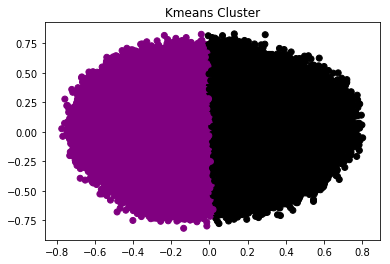

Comparing k-means clusters against the data:
good_loan_status      0      1
row_0                         
0                 10701  32105
1                 11429  33688


In [6]:
colormap = np.array(['black', 'Purple'])
X_norm = normalize(scale(df.drop(['good_loan_status'], axis=1)))
X_pca = PCA(2).fit_transform(X_norm)
y_pred = KMeans(n_clusters=2, random_state=42, n_jobs=-1).fit_predict(X_pca)

# Plot the solution.
plt.title('Kmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[y_pred])
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, df['good_loan_status']))

_PCA is used to reduce the data to 2 components because we are looking to see if Kmeans can predict a good loan_

Looks like this model isn't doing very well. We're __correctly classifying 44,298 (33717+10581)__ cases, but __mis-classifying 43,625 (32076+11549)__ of the cases!

Out of __87,923__ loan applicatons __33717__ were good loans which were predict correctly. There are way to many false positives(__32076__).


-----

## Kmeans Mini Batch

_Let's look at MiniBatch to see if that would be better_

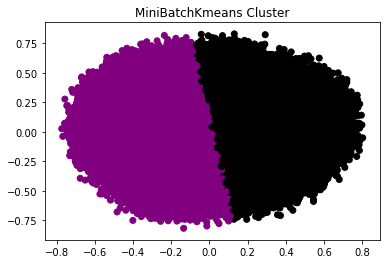

Comparing k-means and mini batch k-means solutions:
good_loan_status      0      1
row_0                         
0                 10391  31302
1                 11739  34491


In [7]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=250)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)
# Plot the solution.
colormap = np.array(['black', 'Purple'])
plt.title('MiniBatchKmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[predict_mini])
plt.show()
# MiniBatch model.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, df['good_loan_status']))

MiniBatch Kmeans is able to __classify 43,207 (32263+10944)___ and __mis-classify 44,716 (11186+33530)__.

-----

-------

# Clustering the Top 10 Random Forest features
_I will take the top 10 features from the Random Forest supervised learning
I will run it on both Kmeans and MeanShift_

In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

df1 = pd.read_csv('lending_club_le.csv',index_col=0)

_Create the dataframes of the top 10 features_

In [9]:
topFeatures = df1[['loan_amnt',
                   'tot_hi_cred_lim',
                   'home_ownership',
                   'verification_status',
                   'dti',
                   'percent_bc_gt_75',
                   'mo_sin_old_rev_tl_op',
                   'all_util',
                   'mths_since_recent_inq',
                   'annual_inc']]

_Elbow method to determine the number of clusters_

In [10]:
# function to determine K
def kClusters(X):
    plt.rcParams['figure.figsize'] = [9, 5]

    squaredSums = []
    K = range(1, 15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel = kmeanModel.fit(X)
        squaredSums.append(kmeanModel.inertia_)

    # Plot the elbow
    plt.plot(K, squaredSums, 'bx-')
    plt.xlabel('k')
    plt.ylabel('squaredSums')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

---

## KMeans RFC top 10 feature analysis

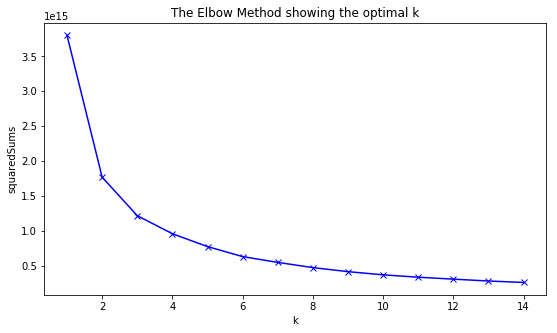

In [11]:
kClusters(topFeatures)

In [15]:
norm = Normalizer(copy=False)
X_normalized = norm.fit_transform(topFeatures)

km = KMeans(n_clusters=4,
               init='k-means++')

km_clusters = km.fit_predict(X_normalized)

centroids = km.cluster_centers_
km_labels = km.labels_

topFeatures['Clusters'] = km_clusters

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [16]:
#clusterList = [0, 1, 2, 3]
#for var in clusterList:
#    print('\ncluster '+str(var))
#    print(topFeatures[topFeatures['clusters'] == var].mean())
#    topFeatures[topFeatures['clusters'] == var].mean().plot(kind='bar')


cluster 0
loan_amnt                13813.410523
tot_hi_cred_lim          31885.553988
home_ownership               2.516015
verification_status          0.781918
dti                          7.916598
percent_bc_gt_75            30.562471
mo_sin_old_rev_tl_op       145.722828
all_util                    49.561018
mths_since_recent_inq        6.814749
annual_inc               91472.125961
Clusters                     0.000000
Name: mean, dtype: float64

cluster 1
loan_amnt                 15940.684675
tot_hi_cred_lim          332180.760529
home_ownership                1.251538
verification_status           0.924411
dti                          22.174473
percent_bc_gt_75             30.780719
mo_sin_old_rev_tl_op        188.578055
all_util                     53.844806
mths_since_recent_inq         6.414459
annual_inc                80850.921541
Clusters                      1.000000
Name: mean, dtype: float64

cluster 2
loan_amnt                 15056.587755
tot_hi_cred_lim          13

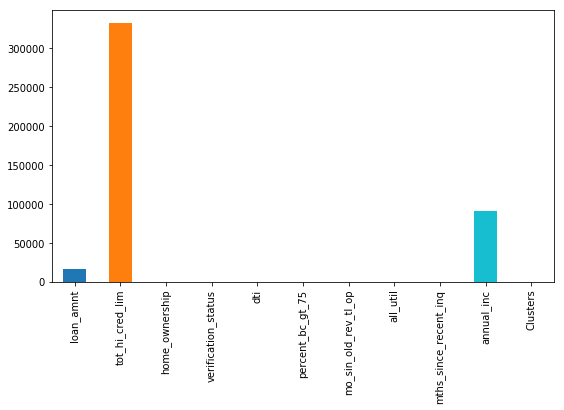

In [17]:
clusterList = [0, 1, 2, 3]
for var in clusterList:
    print('\ncluster '+str(var))
    print(topFeatures[topFeatures['Clusters'] == var].describe().loc['mean'])
    topFeatures[topFeatures['Clusters'] == var].describe().loc['mean'].plot(kind='bar')

__Match the KMean clusters to labels.__

In [18]:
#topFeatures = topFeatures.drop('clusters', axis=1)
dict = {}
for var in zip(topFeatures, km_labels):
    dict[var[0]] = var[1]
dict    

{'loan_amnt': 1,
 'tot_hi_cred_lim': 3,
 'home_ownership': 2,
 'verification_status': 1,
 'dti': 2,
 'percent_bc_gt_75': 2,
 'mo_sin_old_rev_tl_op': 0,
 'all_util': 1,
 'mths_since_recent_inq': 2,
 'annual_inc': 1,
 'Clusters': 1}

In [19]:
km_clusters = pd.DataFrame(list(dict.items()), 
                           columns=['Features', 
                                    'Cluster'])

In [20]:
km_clusters.sort_values(by=['Cluster'], 
                        ascending=[True])

,Features,Cluster
6,mo_sin_old_rev_tl_op,0
0,loan_amnt,1
3,verification_status,1
7,all_util,1
9,annual_inc,1
10,Clusters,1
2,home_ownership,2
4,dti,2
5,percent_bc_gt_75,2
8,mths_since_recent_inq,2


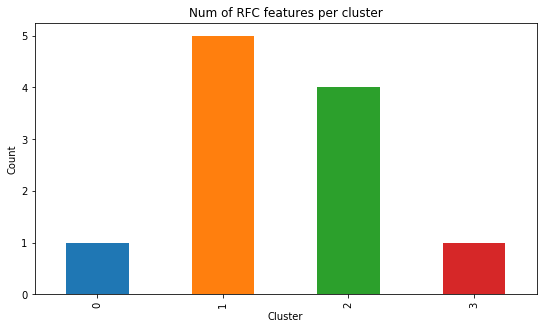

In [21]:
km_clusters.groupby('Cluster')['Features'].nunique().plot(kind='bar');
plt.ylabel('Count')
plt.title('Num of RFC features per cluster');

In [22]:
km_clusters.Cluster.value_counts()

1    5
2    4
3    1
0    1
Name: Cluster, dtype: int64

In [23]:
km_clusters[km_clusters['Cluster'] == 0]

,Features,Cluster
6,mo_sin_old_rev_tl_op,0


In [24]:
km_clusters[km_clusters['Cluster'] == 1]

,Features,Cluster
0,loan_amnt,1
3,verification_status,1
7,all_util,1
9,annual_inc,1
10,Clusters,1


In [25]:
km_clusters[km_clusters['Cluster'] == 2]

,Features,Cluster
2,home_ownership,2
4,dti,2
5,percent_bc_gt_75,2
8,mths_since_recent_inq,2


In [26]:
km_clusters[km_clusters['Cluster'] == 3]

,Features,Cluster
1,tot_hi_cred_lim,3


---------

## Mean shift top 10 feature analysis

In [30]:
#topFeatures2 = topFeatures.drop(
#   ['clusters'], axis=1)

topFeatures2 = df1[['loan_amnt',
                   'tot_hi_cred_lim',
                   'home_ownership',
                   'verification_status',
                   'dti',
                   'percent_bc_gt_75',
                   'mo_sin_old_rev_tl_op',
                   'all_util',
                   'mths_since_recent_inq',
                   'annual_inc']]

In [31]:
bandwidth2 = estimate_bandwidth(topFeatures2,
                                quantile=0.2,
                                n_samples=10)
# introduce the radius, also create bins to store the clusters.
ms = MeanShift(bandwidth2, 
               bin_seeding=True)

In [32]:
ms.fit(topFeatures2)
msLabels = ms.labels_

In [33]:
msLabels

array([0, 0, 0, ..., 1, 0, 0])

In [34]:
dict1 = {}
for var in zip(topFeatures2, msLabels):
    dict1[var[0]] = var[1]
    # if var[1] == 65:
    # print(var)

_This dictionary has the feature and the cluster number it belongs too_

In [35]:
dict1

{'loan_amnt': 0,
 'tot_hi_cred_lim': 0,
 'home_ownership': 0,
 'verification_status': 0,
 'dti': 0,
 'percent_bc_gt_75': 0,
 'mo_sin_old_rev_tl_op': 0,
 'all_util': 0,
 'mths_since_recent_inq': 0,
 'annual_inc': 0}

In [36]:
clusters = pd.DataFrame(list(dict1.items()), columns=[
                        'Features', 'Cluster'])
clusters

,Features,Cluster
0,loan_amnt,0
1,tot_hi_cred_lim,0
2,home_ownership,0
3,verification_status,0
4,dti,0
5,percent_bc_gt_75,0
6,mo_sin_old_rev_tl_op,0
7,all_util,0
8,mths_since_recent_inq,0
9,annual_inc,0


In [37]:
clusters['Cluster'].value_counts()

0    10
Name: Cluster, dtype: int64

_MeanShift didn't find any new features._

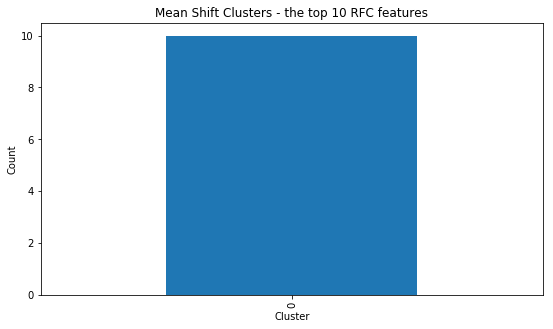

In [38]:
clusters.groupby('Cluster')['Features'].nunique().plot(kind='bar');
plt.ylabel('Count')
plt.title('Mean Shift Clusters - the top 10 RFC features');